In [ ]:
df = pd.read_csv('/sokrat_bot/data.csv', sep = ',')

In [ ]:
! pip install accelerate

In [ ]:
import accelerate

In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup

In [ ]:
seed = 10

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
dfnew = df.dropna(axis = 0)

In [ ]:
dfnew

,Unnamed: 0,Query,Answer,Label,Common
0,0,"Сокр. Ты удивляешься, думаю, сын Клиниаса, что...","Отв. Но, может быть, тебе неизвестно, Сократ, ...",1,"Сокр. Ты удивляешься, думаю, сын Клиниаса, что..."
1,1,"Сокр. Ты удивляешься, думаю, сын Клиниаса, что...","Отв. Без сомнения, буду слушать, — только говори.",1,"Сокр. Ты удивляешься, думаю, сын Клиниаса, что..."
2,2,"Сокр. Ты удивляешься, думаю, сын Клиниаса, что...","Отв. Говори, добряк; а я уж буду слушать.",1,"Сокр. Ты удивляешься, думаю, сын Клиниаса, что..."
3,3,"Сокр. Ты удивляешься, думаю, сын Клиниаса, что...","Отв. Я нахожу, Сократ, что начав говорить, ты ...",1,"Сокр. Ты удивляешься, думаю, сын Клиниаса, что..."
4,4,"Сокр. Ты так спрашиваешь, как будто я должен п...",Отв. Лишь бы тут не требовалось какой-нибудь т...,1,"Сокр. Ты так спрашиваешь, как будто я должен п..."
...,...,...,...,...,...
2535,1265,"Сокр. Скажи же, ради Зевса, в чём состоит то п...","Отв. Если хочешь, пусть и так.",0,"Сокр. Скажи же, ради Зевса, в чём состоит то п..."
2536,1266,"Сокр. Скажи же, ради Зевса, в чём состоит то п...","Отв. Да, Сократ всегда таков, Горгиас: спрашив...",0,"Сокр. Скажи же, ради Зевса, в чём состоит то п..."
2537,1267,"Сокр. Конечно, если бы ты захотел, Эвтифрон, т...",Отв. Правильно. И это будет нам очень полезно ...,0,"Сокр. Конечно, если бы ты захотел, Эвтифрон, т..."
2538,1268,"Сокр. А справедливо просить, не значит ли — пр...","Отв. То, что ты теперь говоришь, справедливо.",0,"Сокр. А справедливо просить, не значит ли — пр..."


In [ ]:
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2538 entries, 0 to 2539
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2538 non-null   int64 
 1   Query       2538 non-null   object
 2   Answer      2538 non-null   object
 3   Label       2538 non-null   int64 
 4   Common      2538 non-null   object
dtypes: int64(2), object(3)
memory usage: 119.0+ KB


In [ ]:
filtered_data =  dfnew.to_dict('records')

In [ ]:
filtered_data

In [ ]:
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
MAX_LENGTH = 128

tokenized_texts = tokenizer([data["Query"] for data in filtered_data],
                            [data["Answer"] for data in filtered_data],
                            max_length=MAX_LENGTH, padding="max_length",
                            truncation=True, verbose=True)

In [ ]:
class StsDataset(Dataset):
    def __init__(self, tokens: dict, labels: list[float]):
        self.tokens = tokens
        self.labels = labels

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {
            "input_ids": torch.tensor(self.tokens["input_ids"][ix], dtype=torch.long),
            "attention_mask": torch.tensor(self.tokens["attention_mask"][ix], dtype=torch.long),
            "labels": torch.tensor(self.labels[ix], dtype=torch.float)  # Use float for regression
        }

    def __len__(self) -> int:
        return len(self.tokens["input_ids"])

In [ ]:
%%time

sts_dataset = StsDataset(tokenized_texts, [data["Label"] for data in filtered_data])

CPU times: user 265 µs, sys: 0 ns, total: 265 µs
Wall time: 274 µs


In [ ]:
train_ratio = 0.8
n_total = len(sts_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(sts_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_dataloader), len(val_dataloader)

(127, 32)

In [ ]:
class CrossEncoderBert(torch.nn.Module):
    def __init__(self, max_length: int = MAX_LENGTH):
        super().__init__()
        self.max_length = max_length
        self.bert_model = tuned_model = AutoModel.from_pretrained('distilbert-base-uncased')
        self.bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use the CLS token's output
        return self.linear(pooled_output)

In [ ]:
def test_cross_encoder_bert():
    max_length = 128
    model = CrossEncoderBert(max_length=max_length)

    # Check __init__ method
    assert model.max_length == max_length, "Incorrect max_length initialization"
    assert isinstance(model.linear, torch.nn.Linear), "linear is not an instance of torch.nn.Linear"
    assert model.linear.in_features == model.bert_model.config.hidden_size, "Incorrect input size for linear layer"

    # Prepare dummy data for forward method check
    input_text = ["Hello, world!"]
    inputs = model.bert_tokenizer(input_text, return_tensors="pt", max_length=max_length, truncation=True, padding=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Check forward method
    output = model(input_ids, attention_mask)
    assert output.shape == (1, 1), "Output shape is incorrect"

    print("All checks passed!")

test_cross_encoder_bert()

All checks passed!


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrossEncoderBert().to(device)

In [ ]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.MSELoss()

In [ ]:
def train_step_fn(model, optimizer, scheduler, loss_fn, batch):
    model.train()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    optimizer.zero_grad()
    logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

def val_step_fn(model, loss_fn, batch):
    model.eval()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    return loss.item()

def mini_batch(dataloader, step_fn, is_training=True):
    mini_batch_losses = []
    for i, batch in enumerate(dataloader):
        if is_training:
            loss = step_fn(model, optimizer, scheduler, loss_fn, batch)
        else:
            loss = step_fn(model, loss_fn, batch)
        mini_batch_losses.append(loss)
        if i % (batch_size * 4) == 0:
            print(f"Step {i:>5}/{len(dataloader)}, Loss = {loss:.3f}")
    return np.mean(mini_batch_losses), mini_batch_losses

In [ ]:
%%time

n_epochs = 2

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}")
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn, is_training=True)
    train_mini_batch_losses.extend(_train_mini_batch_losses)
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses.extend(_val_mini_batch_losses)
        val_losses.append(val_loss)


Epoch 1
Step     0/127, Loss = 0.627
Step    64/127, Loss = 0.249
Step     0/32, Loss = 0.263

Epoch 2
Step     0/127, Loss = 0.260
Step    64/127, Loss = 0.241
Step     0/32, Loss = 0.263
CPU times: user 45.7 s, sys: 140 ms, total: 45.8 s
Wall time: 48.3 s


In [ ]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

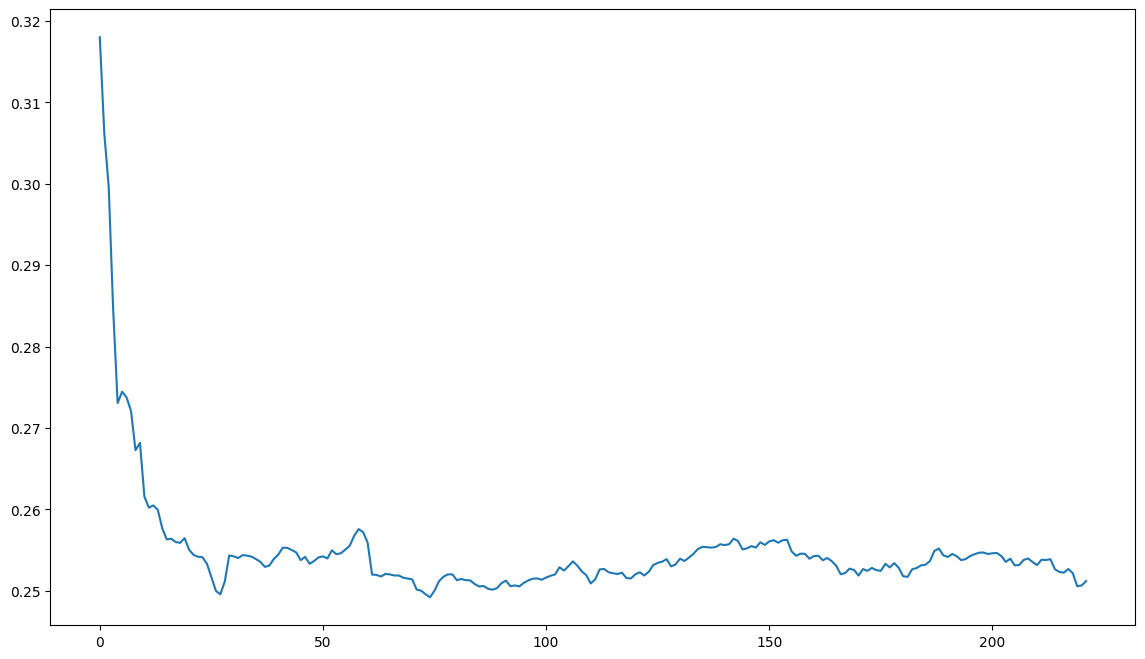

In [ ]:
fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

In [ ]:
model.bert_model.save_pretrained("/sokrat_bot/sbert_softmax_lr_2e-6_2_crossencoder")

In [ ]:
model_tuned = model.bert_model.save_pretrained("/sokrat_bot/sbert_softmax_lr_2e-6_2_crossencoder")

In [ ]:
device = 'cuda'

In [ ]:
import gc

In [ ]:
corpus = dfnew['Answer'].to_list()
corpus = corpus[:1100]

In [ ]:
def get_ranked_docs(query, corpus = corpus, tokenizer = tokenizer, finetuned_ce = model) -> None:
    seed = random.choice([10,4,8,29,31,16])
    random.seed(seed)
    random.shuffle(corpus)
    i = random.choice([1,200,500,700,1000])
    corpus_small = corpus[i:i+300]
    queries = [query] * len(corpus_small)
    tokenized_texts = tokenizer(
        queries, corpus_small, max_length=MAX_LENGTH, padding=True, truncation=True, return_tensors="pt"
    ).to(device)

    # Finetuned CrossEncoder model scoring
    with torch.no_grad():
        ce_scores = finetuned_ce(tokenized_texts['input_ids'], tokenized_texts['attention_mask']).squeeze(-1)
        ce_scores = torch.sigmoid(ce_scores)  # Apply sigmoid if needed

    # Process scores for finetuned model
    print(f"Query - {query} [Finetuned Cross-Encoder]\n---")
    scores = ce_scores.cpu().numpy()
    scores_ix = np.argsort(scores)[::-1]
    print(scores_ix[0])
    for ix in scores_ix[0:1]:  # Limit to corpus size
        answer = f"{scores[ix]: >.2f} {corpus_small[ix]}"
    gc.collect()
    torch.cuda.empty_cache()
    return answer

In [ ]:
query = "Я бывал в разных странах."

In [ ]:
get_ranked_docs(query=query)

Query - Я бывал в разных странах. [Finetuned Cross-Encoder]
---
24


'0.62 Отв. Что же из того?'

In [ ]:
query = "Какими качествами обладает справедливый человек?"

In [ ]:
get_ranked_docs(query=query)

Query - Какими качествами обладает справедливый человек? [Finetuned Cross-Encoder]
---
96


'0.61\tОтв. Как же и что скажешь ты?'

In [ ]:
query = "Прекрасная сегодня погода!"
get_ranked_docs(query=query)

Query - Прекрасная сегодня погода! [Finetuned Cross-Encoder]
---
97


'0.61\tОтв. Почему и чего боишься ты, что так говоришь?'

In [ ]:
query = "Справедливость - это добродетель."
get_ranked_docs(query=query)

Query - Справедливость - это добродетель. [Finetuned Cross-Encoder]
---
25


'0.61\tОтв. Так что ж из этого?'

In [ ]:
query = "Какие искуства ты знаешь?"
get_ranked_docs(query=query)

Query - Какие искуства ты знаешь? [Finetuned Cross-Encoder]
---
2


'0.62\tОтв. Что ты? разве в этом-то всё счастье?'

In [ ]:
query = "Дважды два - четыре."
get_ranked_docs(query=query)

Query - Дважды два - четыре. [Finetuned Cross-Encoder]
---
16


'0.62\tОтв. А то что еще?'

In [ ]:
query = "В чём смысл жизни, как, по-твоему? В постоянных наслаждениях?"
get_ranked_docs(query=query)

Query - В чём смысл жизни, как, по-твоему? В постоянных наслаждениях? [Finetuned Cross-Encoder]
---
16


'0.61\tОтв. Как же иначе было бы, Сократ?'

In [ ]:
query = "Справедливость полезна или нет? Думаю, что полезна."
get_ranked_docs(query=query)

Query - Справедливость полезна или нет? Думаю, что полезна. [Finetuned Cross-Encoder]
---
60


'0.61\tОтв. Не то ли уж нужно знать этому вопрошателю, Сократ, что̀ прекрасно?'

In [ ]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 10.6 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl siz

In [ ]:
import gradio as gr

In [ ]:
def greet(name, intensity):
    return "Hello, " + name + "!" * int(intensity)

demo = gr.Interface(
    fn=get_ranked_docs,
    inputs=["text"],
    outputs=["text"],
)

demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://f573c5859b4b9e615d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
